# Bibliotecas

In [40]:
import importlib
import subprocess
import sys

# Mapeo de imports → nombres reales de paquetes en pip
required_packages = {
    "numpy": "numpy",
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "scipy": "scipy",
    "seaborn": "seaborn",
    "statsmodels": "statsmodels",
    "sklearn": "scikit-learn",   # <- CORRECCIÓN
    "plotly": "plotly",
    "stargazer": "stargazer",
}

def safe_pip_install(package):
    """Instala un paquete si no está, sin actualizar."""
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
        print(f"✓ {package} instalado correctamente.")
    except Exception:
        print(f"⚠ No se pudo instalar {package}. Puede estar bloqueado por Anaconda.")

def install_if_missing(import_name, pip_name):
    try:
        importlib.import_module(import_name)
        print(f"✔ {import_name} ya está instalado.")
    except ImportError:
        print(f"✖ {import_name} no está instalado. Instalando {pip_name}...")
        safe_pip_install(pip_name)

print("📦 Verificando librerías necesarias...\n")

for import_name, pip_name in required_packages.items():
    install_if_missing(import_name, pip_name)

print("\n🎉 Todas las librerías están listas.")


📦 Verificando librerías necesarias...

✔ numpy ya está instalado.
✔ pandas ya está instalado.
✔ matplotlib ya está instalado.
✔ scipy ya está instalado.
✔ seaborn ya está instalado.
✔ statsmodels ya está instalado.
✔ sklearn ya está instalado.
✔ plotly ya está instalado.
✔ stargazer ya está instalado.

🎉 Todas las librerías están listas.


In [41]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import pointbiserialr
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from stargazer.stargazer import Stargazer
from scipy import stats
from IPython.core.display import display, HTML
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from IPython.display import clear_output, display

C:\Users\alexf\AppData\Local\Temp\ipykernel_14804\1825404072.py:13: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



# LIMPIEZA 

## lectura dfs

In [42]:
import pandas as pd
import os
import warnings

def leer_excel_auto(filepath, header=None):
    ext = os.path.splitext(filepath)[1].lower()
    if ext == ".xls":
        return pd.read_excel(filepath, header=header, engine="xlrd")
    else:
        return pd.read_excel(filepath, header=header, engine="openpyxl")


def limpiar_serie_bcentral_adaptable(filepath, nombre):
    """
    Limpia cualquier archivo Excel del Banco Central, sin depender de nombres de columnas.
    Detecta automáticamente la columna de fechas y las columnas de valores.
    
    Si el archivo no existe, devuelve un DataFrame vacío y muestra un mensaje.
    """
    if not os.path.exists(filepath):
        print(f"⚠️ El archivo no se encontró: {filepath}")
        return pd.DataFrame(columns=["Mes", nombre])

    # Leer archivo sin encabezado
    df_raw = leer_excel_auto(filepath, header=None)

    # Buscar automáticamente la fila donde comienzan los datos (primera fila con fecha válida)
    start_row = None
    for i, row in df_raw.iterrows():
        for val in row:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                try:
                    pd.to_datetime(val, errors='raise')
                    start_row = i
                    break
                except Exception:
                    continue
        if start_row is not None:
            break
    if start_row is None:
        print("⚠️ No se pudo encontrar una fila con fechas válidas.")
        return pd.DataFrame(columns=["Mes", nombre])

    # Extraer datos desde esa fila
    df = df_raw.iloc[start_row:].reset_index(drop=True)

    # Usar la fila anterior como encabezado si tiene nombres, si no usar genéricos
    header_row = df_raw.iloc[start_row - 1].tolist() if start_row > 0 else [f"Col{i}" for i in range(df.shape[1])]
    header_row = [str(h) if str(h) != 'nan' else f"Col{i}" for i, h in enumerate(header_row)]
    df.columns = header_row

    # Detectar automáticamente columna de fecha
    fecha_col = None
    for col in df.columns:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                pd.to_datetime(df[col], errors='raise')
                fecha_col = col
                break
            except Exception:
                continue
    if fecha_col is None:
        fecha_col = df.columns[0]

    # Detectar columna de valor
    valor_col = None
    for col in df.columns:
        if col != fecha_col:
            if pd.to_numeric(df[col], errors='coerce').notna().any():
                valor_col = col
                break
    if valor_col is None:
        valor_col = df.columns[1]

    # Convertir tipos (sin warnings)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        df[fecha_col] = pd.to_datetime(df[fecha_col], errors='coerce')
    df[valor_col] = pd.to_numeric(df[valor_col], errors='coerce')

    # Eliminar filas vacías
    df = df.dropna().reset_index(drop=True)

    # Renombrar columnas
    df = df.rename(columns={fecha_col: "Mes", valor_col: nombre})

    return df

def combinar_series(df_list, nombres=None, start_year=2010):
    """
    Combina varias series temporales por la columna 'Mes', ignorando DataFrames vacíos.
    
    Parámetros:
        df_list (list of pd.DataFrame): Lista de DataFrames ya limpiados con columnas 'Mes' y 'Valor'.
        nombres (list of str, opcional): Nombres que se asignarán a las columnas de valor.
        start_year (int, opcional): Año desde el cual filtrar las series.
    
    Retorna:
        pd.DataFrame: DataFrame combinado, ordenado por 'Mes', con columnas renombradas.
    """
    # Filtrar cada df por start_year y eliminar df vacíos
    df_filtrados = [
        df[df["Mes"].dt.year >= start_year].reset_index(drop=True)
        for df in df_list
        if not df.empty
    ]
    
    if not df_filtrados:
        print("⚠️ Todos los DataFrames están vacíos. Retornando un DataFrame vacío.")
        return pd.DataFrame()

    # Renombrar columnas de valor si se provee nombres
    if nombres is not None:
        # Solo considerar nombres para los df que no están vacíos
        nombres_filtrados = [nombre for df, nombre in zip(df_list, nombres) if not df.empty]
        if len(nombres_filtrados) != len(df_filtrados):
            raise ValueError("La cantidad de nombres no coincide con la cantidad de DataFrames no vacíos.")
        for df, nombre in zip(df_filtrados, nombres_filtrados):
            if "Valor" in df.columns:
                df.rename(columns={"Valor": nombre}, inplace=True)
    
    # Merge sucesivo
    df_final = df_filtrados[0]
    for df in df_filtrados[1:]:
        df_final = df_final.merge(df, on="Mes", how="inner")
    
    # Ordenar cronológicamente
    df_final = df_final.sort_values("Mes").reset_index(drop=True)
    
    # Crear columna con inflación del mes anterior si existe 'Inflacion'
    if "Inflacion" in df_final.columns:
        df_final["Inflacion_anterior"] = df_final["Inflacion"].shift(1)
        df_final.loc[0, "Inflacion_anterior"] = df_final.loc[0, "Inflacion"]
    
    return df_final


In [43]:
df1 = limpiar_serie_bcentral_adaptable("indicador.xls","Inflacion")
df2 = limpiar_serie_bcentral_adaptable("ED_TDNRM2.xlsx","Desempleo")
df3 = limpiar_serie_bcentral_adaptable("EXE_BCCH_01.xlsx","Expectativa_Inflacion")
df4 = limpiar_serie_bcentral_adaptable("DOLAR_OBS_ADO (1).xlsx","valor del dolar")
df5 = limpiar_serie_bcentral_adaptable("EI_MON_POL_D.xlsx","tasa politica monetaria")
df6 = limpiar_serie_bcentral_adaptable("F019PPBPRE40M.xlsx","precio del cobre")
df7 = limpiar_serie_bcentral_adaptable("F021M1STONCLP5M.xlsx","M1")
df8 = limpiar_serie_bcentral_adaptable("IMACEC.xls","IMACEC")
df9 = limpiar_serie_bcentral_adaptable("EI_EPU.xlsx","incertudumbre politica econimica")
df9 = df9[["Mes","incertudumbre politica econimica"]]
df10= limpiar_serie_bcentral_adaptable("expectativa inflacion mes siguiente.xlsx","expectativa inflacion mes siguiente")
df11= limpiar_serie_bcentral_adaptable("F032IMCINDZZEP18N03Z0M.xlsx","IMACEC NO MINERO")
df12= limpiar_serie_bcentral_adaptable("EXE_IPEC_01_M2.xlsx","Situacion economica")
df13= limpiar_serie_bcentral_adaptable("ED_VAR_REM_M_2023_EMP.xlsx","indice real de remuneraciones")

WARNING *** file size (69942) not 512 + multiple of sector size (512)
⚠️ El archivo no se encontró: F032IMCINDZZEP18N03Z0M.xlsx
⚠️ El archivo no se encontró: EXE_IPEC_01_M2.xlsx


## df final

In [44]:
df_final = combinar_series([df1, df2,df3,df7,df10,df13], nombres=["Inflacion","Desempleo","Expectativa_Inflacion","M1","expectativa inflacion mes siguiente","indice real de remuneraciones"]) 
df_final.tail(5)

,Mes,Inflacion,Desempleo,Expectativa_Inflacion,M1,expectativa inflacion mes siguiente,indice real de remuneraciones,Inflacion_anterior
182,2025-05-01,0.2,8.943014,0.2,61745.159747,0.1,0.124334,0.2
183,2025-06-01,-0.4,8.892661,0.0,61045.761288,0.4,1.100880,0.2
184,2025-07-01,0.9,8.698979,0.6,61508.745891,0.2,-0.379970,-0.4
185,2025-08-01,0.0,8.561129,0.2,61277.342094,0.4,0.158283,0.9
186,2025-09-01,0.4,8.528949,0.4,61641.396255,0.3,-0.031310,0.0


In [45]:
import pandas as pd

def filtrar_por_anio(df, anio_inicio=None, anio_fin=None):
    """
    Filtra un DataFrame por rango de años usando la columna 'Mes'.
    
    Parámetros:
        df (pd.DataFrame): DataFrame con columna 'Mes' tipo datetime.
        anio_inicio (int, opcional): Año inicial (inclusive). Si es None, se toma el primer año disponible.
        anio_fin (int, opcional): Año final (inclusive). Si es None, se toma el último año disponible.
        
    Retorna:
        pd.DataFrame: DataFrame filtrado por el rango de años.
    """
    if 'Mes' not in df.columns:
        raise ValueError("El DataFrame debe tener una columna llamada 'Mes' de tipo datetime.")
    
    df_filtrado = df.copy()
    
    if anio_inicio is not None:
        df_filtrado = df_filtrado[df_filtrado['Mes'].dt.year >= anio_inicio]
    if anio_fin is not None:
        df_filtrado = df_filtrado[df_filtrado['Mes'].dt.year <= anio_fin]
    
    return df_filtrado.reset_index(drop=True)

# Ejemplo de uso
# Supongamos que tu DataFrame se llama df_final


# MODELOS

## Sin restringuir

In [46]:
import statsmodels.api as sm

# Asegurar que "Mes" sea tipo datetime
df_final["Mes"] = pd.to_datetime(df_final["Mes"])

# Filtrar solo años 2023 y 2024
df_filtrado = filtrar_por_anio(df_final, anio_inicio=2010, anio_fin=2025)

# Calcular diferencia entre inflación observada y esperada
df_filtrado = df_filtrado.dropna()
# Variables para la regresión
X = sm.add_constant(df_filtrado[["Expectativa_Inflacion","Inflacion_anterior","M1","Desempleo","indice real de remuneraciones"]])
Y = df_filtrado["Inflacion"]

# Ajustar modelo OLS
model = sm.OLS(Y, X)
results = model.fit()

# Mostrar resumen
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              Inflacion   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     57.32
Date:               mar, 25 nov. 2025   Prob (F-statistic):           1.59e-35
Time:                        10:55:21   Log-Likelihood:                 6.3441
No. Observations:                 187   AIC:                           -0.6881
Df Residuals:                     181   BIC:                             18.70
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

## Restringuido

In [47]:
import statsmodels.api as sm

# Asegurar que "Mes" sea tipo datetime
df_final["Mes"] = pd.to_datetime(df_final["Mes"])

# Filtrar años
df_filtrado = filtrar_por_anio(df_final, anio_inicio=2010, anio_fin=2025)

# Elimina NA's relevantes
df_filtrado = df_filtrado.dropna(subset=[
    "Inflacion",
    "Inflacion_anterior",
    "Expectativa_Inflacion",
    "M1",
    "Desempleo",
    "indice real de remuneraciones"
])

# ============================
#   REPARAMETRIZACIÓN
# ============================

# Y* = Inflacion - Inflacion_anterior
Y_star = df_filtrado["Inflacion"] - df_filtrado["Inflacion_anterior"]

# Z = Expectativa_Inflacion - Inflacion_anterior
df_filtrado["Z"] = df_filtrado["Expectativa_Inflacion"] - df_filtrado["Inflacion_anterior"]

# Matriz de regresores con la nueva variable Z
X_star = sm.add_constant(df_filtrado[[
    "Z",
    "M1",
    "Desempleo",
    "indice real de remuneraciones"
]])

# Ajustar modelo OLS en el sistema reparametrizado
model_star = sm.OLS(Y_star, X_star)
results_star = model_star.fit()

print(results_star.summary())

# ============================
#   RECUPERAR COEFICIENTES
# ============================

beta_exp = results_star.params["Z"]
beta_lag = 1 - beta_exp

print("\nCoeficientes bajo la restricción β_exp + β_lag = 1:")
print(f"beta_Expectativa_Inflacion     = {beta_exp}")
print(f"beta_Inflacion_anterior        = {beta_lag}")
print(f"intercepto (const)             = {results_star.params['const']}")
print(f"beta_M1                        = {results_star.params['M1']}")
print(f"beta_Desempleo                 = {results_star.params['Desempleo']}")
print(f"beta_indice_real_remuneraciones = {results_star.params['indice real de remuneraciones']}")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     130.3
Date:               mar, 25 nov. 2025   Prob (F-statistic):           2.64e-52
Time:                        10:55:21   Log-Likelihood:                 5.2019
No. Observations:                 187   AIC:                           -0.4038
Df Residuals:                     182   BIC:                             15.75
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

# Graficos

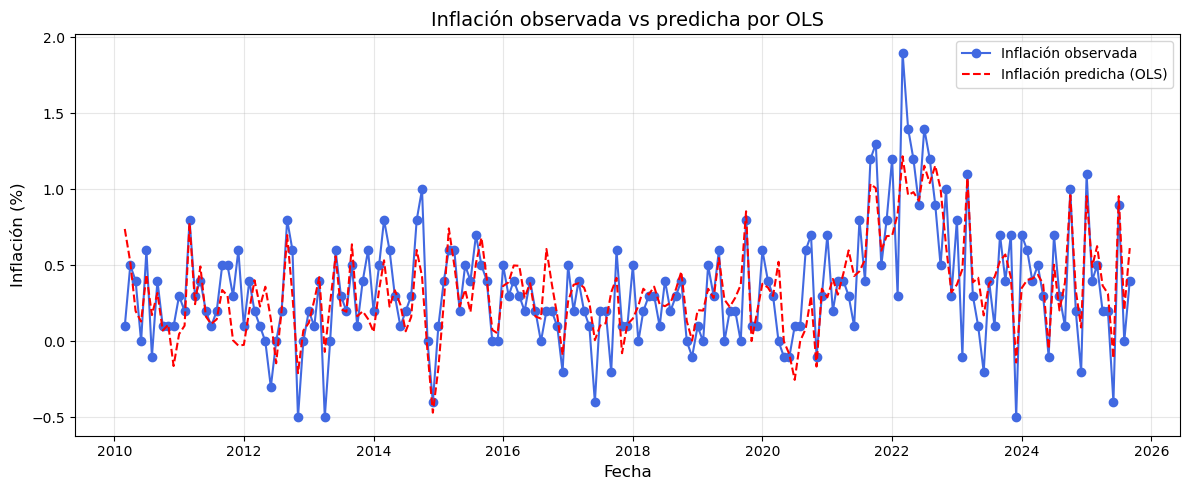

In [48]:
# Obtener predicciones del modelo
df_filtrado["Inflacion_pred"] = results.predict(X)
df_filtrado["Inflacion_pred_restr"] =df_filtrado["Inflacion_anterior"]+results_star.predict(X_star)
# Graficar serie de inflación observada y predicha
plt.figure(figsize=(12, 5))
plt.plot(df_filtrado["Mes"], df_filtrado["Inflacion"], marker="o", linestyle="-", color="royalblue", label="Inflación observada")
plt.plot(df_filtrado["Mes"], df_filtrado["Inflacion_pred"], linestyle="--", color="red", label="Inflación predicha (OLS)")

# Decorar gráfico
plt.title("Inflación observada vs predicha por OLS", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Inflación (%)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
import plotly.express as px

# Crear DataFrame en formato "largo" para Plotly
df_plot = df_filtrado.melt(
    id_vars="Mes",
    value_vars=["Inflacion", "Inflacion_pred", "Inflacion_pred_restr"],
    var_name="Serie",
    value_name="Inflación (%)"
)

# Renombrar para que se vea más bonito en la leyenda
df_plot["Serie"] = df_plot["Serie"].map({
    "Inflacion": "Inflación observada",
    "Inflacion_pred": "Predicción OLS",
    "Inflacion_pred_restr": "Predicción modelo restringido"
})

# Crear gráfico interactivo
fig = px.line(
    df_plot,
    x="Mes",
    y="Inflación (%)",
    color="Serie",
    title="Inflación observada vs predicha (OLS vs Modelo restringido)",
    markers=True  # líneas + puntos en una sola opción
)

# Mejoras visuales
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=3, label="3M", step="month", stepmode="backward"),
                dict(count=6, label="6M", step="month", stepmode="backward"),
                dict(count=1, label="1Y", step="year", stepmode="backward"),
                dict(step="all", label="Todo")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    legend=dict(x=0.02, y=0.98)
)

fig.show()
fig.write_html("grafico_interactivo.html")


c:\Users\alexf\anaconda\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\alexf\anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [50]:
fig = px.line(
    df_plot,
    x="Mes",
    y="Inflación (%)",
    color="Serie",
    markers=False
)

# Paleta tipo Springer/Elsevier
colores_science = {
    "Inflación observada": "#1b4f72",
    "Predicción OLS": "#b03a2e",
    "Predicción modelo restringido": "#1e8449",
}

fig.for_each_trace(lambda t: t.update(line=dict(color=colores_science[t.name], width=2)))

# Fondo blanco + grilla suave
fig.update_layout(
    plot_bgcolor="white",
    paper_bgcolor="white"
)
fig.update_xaxes(showgrid=True, gridcolor="rgba(0,0,0,0.1)")
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.1)")

# Leyenda reducida profesional
fig.update_layout(
    legend=dict(
        x=0.01, y=0.99,
        font=dict(size=10),
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="rgba(0,0,0,0.2)",
        borderwidth=1,
        itemwidth=30
    )
)

fig.update_layout(
    title=dict(text="Inflación observada vs predicha", x=0.5, font=dict(size=16))
)




c:\Users\alexf\anaconda\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\alexf\anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# TEST ESTADISTICOS

## grafico residuos no restriguido

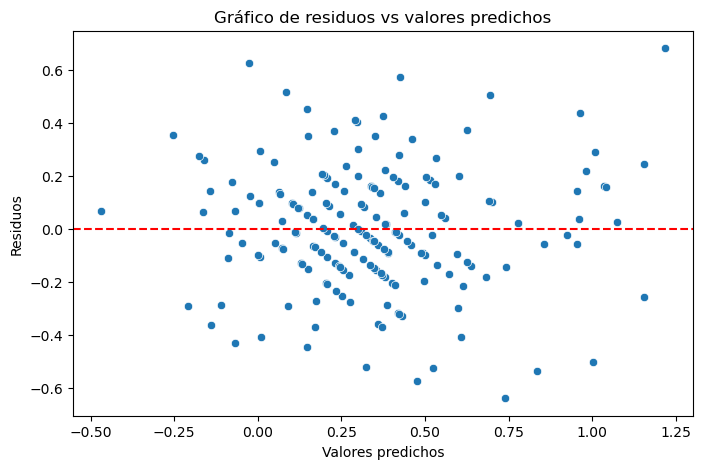

In [51]:
# Obtener predicciones y residuos
y_pred = results.predict(X)
residuos = Y - y_pred  # o: modelo.resid

# Gráfico de residuos vs valores predichos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos vs valores predichos')
plt.show()

## grafico residuos restringuido

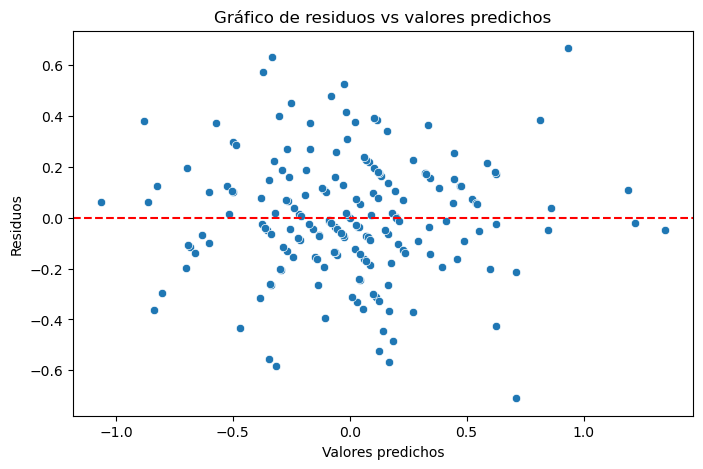

In [52]:
# Obtener predicciones y residuos

residuos = results_star.resid  # o: modelo.resid

# Gráfico de residuos vs valores predichos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=results_star.predict(X_star), y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos vs valores predichos')
plt.show()

In [53]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

def white_test_model(model, X=None, y=None):
    """
    Realiza el Test de White para heterocedasticidad.
    
    - model: modelo entrenado (sklearn o statsmodels)
    - X: DataFrame o array de variables explicativas (solo si es sklearn)
    - y: Series o array de variable dependiente (solo si es sklearn)
    """
    # Detectar tipo de modelo
    if hasattr(model, "resid"):  # statsmodels
        residuos = model.resid
        X_design = model.model.exog
    else:  # sklearn
        if X is None or y is None:
            raise ValueError("Para modelos sklearn debes proporcionar X e y")
        # Escalar si el modelo tiene scaler
        if hasattr(model, "scaler"):
            X_scaled = model.scaler.transform(X)
        else:
            X_scaled = X.values if isinstance(X, pd.DataFrame) else X
        # Predecir y obtener residuos
        y_pred = model.predict(X_scaled)
        residuos = y - y_pred
        # Agregar constante para test
        X_design = sm.add_constant(X_scaled)
    
    # Test de White
    stat, p_value, f_stat, f_p_value = het_white(residuos, X_design)
    
    # Mostrar resultados
    print("✅ Test de White para heterocedasticidad")
    print("-------------------------------")
    print(f"Estadístico Chi-cuadrado: {stat:.4f}, p-valor: {p_value:.4f}")
    print(f"Estadístico F: {f_stat:.4f}, p-valor F: {f_p_value:.4f}")
    
    if p_value < 0.05:
        print("❌ Se rechaza H0: existe heterocedasticidad.")
    else:
        print("✅ No se rechaza H0: no se detecta heterocedasticidad.")
    
    return stat, p_value, f_stat, f_p_value


## test de white modelo sin restriccion

In [54]:
white_test_model(results)


✅ Test de White para heterocedasticidad
-------------------------------
Estadístico Chi-cuadrado: 23.4832, p-valor: 0.2657
Estadístico F: 1.1920, p-valor F: 0.2669
✅ No se rechaza H0: no se detecta heterocedasticidad.


(23.483217898126377,
 0.2656947626630149,
 1.1919920759755194,
 0.2668873509640277)

## test de white modelo restringuido

In [55]:
white_test_model(results_star)

✅ Test de White para heterocedasticidad
-------------------------------
Estadístico Chi-cuadrado: 16.2785, p-valor: 0.2967
Estadístico F: 1.1715, p-valor F: 0.3011
✅ No se rechaza H0: no se detecta heterocedasticidad.


(16.27851881290865, 0.29666303369548175, 1.171459090791572, 0.3011270807982523)

## VIF

In [56]:
import pandas as pd
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calcular_vif_modelo(df, variables):
    """
    Calcula el VIF solo para las variables incluidas en el modelo OLS.
    
    - df: DataFrame con datos.
    - variables: lista de variables explicativas del modelo.
    
    Retorna un DataFrame con el VIF de cada variable.
    """
    datos = df[variables].dropna()
    X_const = add_constant(datos)
    
    vif_data = pd.DataFrame()
    vif_data["variable"] = X_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    
    return vif_data

# -----------------------------
# Ejemplo de uso con tu modelo
variables_modelo = ["Expectativa_Inflacion", "Inflacion_anterior","M1","Desempleo","indice real de remuneraciones"]
vif_result = calcular_vif_modelo(df_filtrado, variables_modelo)

print(vif_result)

                        variable        VIF
0                          const  43.473630
1          Expectativa_Inflacion   1.337385
2             Inflacion_anterior   1.361472
3                             M1   2.064509
4                      Desempleo   1.780909
5  indice real de remuneraciones   1.169686


In [57]:
import pandas as pd

def matriz_correlaciones_modelo(df, variables):
    """
    Calcula la matriz de correlaciones solo para las variables incluidas en el modelo.
    
    - df: DataFrame con datos.
    - variables: lista de variables explicativas del modelo.
    
    Retorna un DataFrame con la matriz de correlaciones.
    """
    datos = df[variables].dropna()
    corr_matrix = datos.corr()
    return corr_matrix

# -----------------------------
# Ejemplo de uso con tu modelo
variables_modelo = ["Expectativa_Inflacion", "Inflacion_anterior", "M1",
                    "Desempleo", "indice real de remuneraciones"]

corr_result = matriz_correlaciones_modelo(df_filtrado, variables_modelo)

print(corr_result)


                               Expectativa_Inflacion  Inflacion_anterior  \
Expectativa_Inflacion                       1.000000            0.396162   
Inflacion_anterior                          0.396162            1.000000   
M1                                          0.323150            0.317380   
Desempleo                                   0.103549            0.019313   
indice real de remuneraciones              -0.326951           -0.291337   

                                     M1  Desempleo  \
Expectativa_Inflacion          0.323150   0.103549   
Inflacion_anterior             0.317380   0.019313   
M1                             1.000000   0.629559   
Desempleo                      0.629559   1.000000   
indice real de remuneraciones -0.108664  -0.063530   

                               indice real de remuneraciones  
Expectativa_Inflacion                              -0.326951  
Inflacion_anterior                                 -0.291337  
M1                           

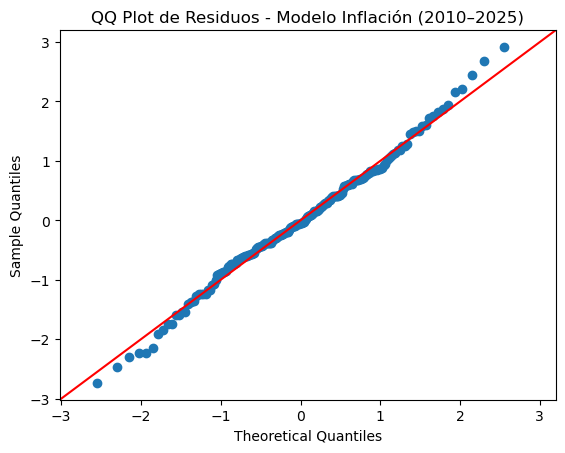

In [58]:
# === QQ PLOT DE RESIDUOS ===
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.qqplot(results.resid, line='45', fit=True)
plt.title("QQ Plot de Residuos - Modelo Inflación (2010–2025)")
plt.show()
